### Weakly Supervised Image Segmentation

Create  your  weak  annotations  (point  clicks)  which  you  will  use  to  train  a  weaklysupervised segmentation model. 

### 1º Form of annotations: Strategy 1.

We made random annotations, using a variance so that they are not very closed, and using a mrgin on the background for them to not being near the lession boundary.

In [4]:
import random
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

def generate_clicks(mask, num_positives, num_negatives, margin, var):

    # Get object (foregorund) and background pixels
    object_pixels = np.argwhere(mask==True)
    lesion_dilated = binary_dilation(mask, iterations=margin)  # Dilate lesion area by margin
    background_pixels = np.argwhere((mask == False) & (~lesion_dilated))
    
    # Function to check if the new point is sufficiently distant from existing points
    def is_dispersed(new_point, existing_points, min_distance):
        for point in existing_points:
            if np.linalg.norm(new_point - point) < min_distance:
                return False
        return True

    # Sample positive clicks from object pixels
    positive_clicks=[] # List of random positions for positive clicks
    while len(positive_clicks) < num_positives:
        new_pos_click = random.choice(object_pixels)
        if is_dispersed(new_pos_click, positive_clicks, var):
            positive_clicks.append(new_pos_click)

    # Sample negative clicks from background pixels
    negative_clicks=[]
    while len(negative_clicks) < num_negatives:
        new_neg_click= random.choice(background_pixels)
        if is_dispersed(new_neg_click, negative_clicks, var):
            negative_clicks.append(new_neg_click)

    return positive_clicks, negative_clicks

# Define the function to draw the ramdom points in the mask

def draw_clicks_on_original(image_path, positive_clicks, negative_clicks, circle_radius,border_thickness):
    # Create a copy of the mask to draw on
    original_image = Image.open(image_path).convert('RGB')  
    draw = ImageDraw.Draw(original_image)

    # Draw positive clicks (in green)
    for (y,x) in positive_clicks:
        # Draw outer circle for black border
        draw.ellipse((x - circle_radius - border_thickness, y - circle_radius - border_thickness,
                      x + circle_radius + border_thickness, y + circle_radius + border_thickness), fill="black")
        # Draw inner green circle
        draw.ellipse((x- circle_radius, y-circle_radius, x + circle_radius, y+ circle_radius), outline='green', fill='green') 

    for (y,x) in negative_clicks:
        # Draw outer circle for black border
        draw.ellipse((x - circle_radius - border_thickness, y - circle_radius - border_thickness,
                      x + circle_radius + border_thickness, y + circle_radius + border_thickness), fill="black")
        # Draw inner red circle
        draw.ellipse((x-circle_radius, y-circle_radius, x + circle_radius, y + circle_radius), outline='red', fill='red')

    return original_image

We now generate the images.

In [ ]:
# See how they perfom on an example

# Load the mask as an image
image_path_mask = 'IMD010_lesion.bmp' 
image_path_original='IMD010.bmp'
mask = Image.open(image_path_mask) 
mask_np = np.array(mask)  # Convert to a NumPy array

# Generate the points
positive_clicks, negative_clicks = generate_clicks(mask_np, num_positives=5, num_negatives=6, margin=5, var=30)

# Draw the circles on the mask image
original_image_with_clicks = draw_clicks_on_original(image_path_original, positive_clicks, negative_clicks, circle_radius=7, border_thickness=2)

# Display the resulting mask with circles
plt.figure(figsize=(8, 8))
plt.imshow(original_image_with_clicks)
plt.axis('off')  # Hide the axes
plt.show()

### 2º Form of annotations: Strategy 2.

We tried now, another method. We use the K-Means-Clustering for determining the best pixels to be selected in the lession and the background.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

def generate_clustered_annotations(mask, num_clusters_pos, num_clusters_neg, margin):
    # Obtener índices de la lesión y el fondo
    lesion_pixels = np.argwhere(mask == True)
    background_pixels = np.argwhere(mask == False)
    
    # Aplicar K-Means para los píxeles de la lesión
    kmeans = KMeans(n_clusters=num_clusters_pos, random_state=0).fit(lesion_pixels)
    positive_clicks = kmeans.cluster_centers_.astype(int)  # Centroides de los clusters
    
    # Filtrar los índices de fondo con un margen
    from scipy.ndimage import binary_dilation
    lesion_dilated = binary_dilation(mask, iterations=margin)
    background_pixels_margin = np.argwhere((mask == 0) & (~lesion_dilated))
    
    # Seleccionar puntos negativos aleatorios
    kmeans_background = KMeans(n_clusters=num_clusters_neg, random_state=0).fit(background_pixels_margin)
    negative_clicks = kmeans_background.cluster_centers_.astype(int) 

    return positive_clicks, negative_clicks


We now see an example of performance.

In [ ]:
# Loop through the DataLoader
#for i, (image, mask) in enumerate(dataloader):

# Load the mask as an image
image_path_mask = 'IMD010_lesion.bmp' 
image_path_original='IMD010.bmp'
mask = Image.open(image_path_mask) 
mask_np = np.array(mask)  # Convert to a NumPy array

# Generate the points
positive_clicks, negative_clicks = generate_clustered_annotations(mask_np, num_clusters_pos=5, num_clusters_neg=5, margin=5)

# Draw the circles on the mask image
original_image_with_clicks = draw_clicks_on_original(image_path_original, positive_clicks, negative_clicks, circle_radius=7, border_thickness=2)

# Display the resulting mask with circles
plt.figure(figsize=(8, 8))
plt.imshow(original_image_with_clicks)
plt.axis('off')  # Hide the axes
plt.show()

### Optional 3º: Box annotation.

In [28]:
import numpy as np
import cv2
def calculate_bounding_box(mask):
    lession_pixels = np.argwhere(mask == True)
    background_pixels = np.argwhere(mask == False)

    # Found the limits of the lession
    y_min, x_min = np.min(lession_pixels, axis=0)
    y_max, x_max = np.max(lession_pixels, axis=0)

    # Bounding box
    bounding_box = (y_min, x_min, y_max, x_max)
    return bounding_box

# Define a function to see performance.
def draw_box_in_original(original_image_path, box):
    original_image = Image.open(original_image_path).convert('RGB') 
    original_image_np = np.array(original_image)
    y_min, x_min, y_max, x_max = box
    image_with_box = original_image_np.copy()
    cv2.rectangle(image_with_box, (x_min,y_min), (x_max,y_max), (0,255,0),2)
    return image_with_box

We now show an example of performance.

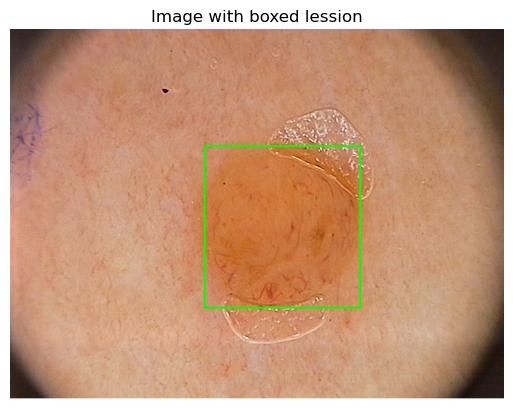

In [29]:
import matplotlib.pyplot as plt
image_path_mask = 'IMD010_lesion.bmp' 
image_path_original='IMD010.bmp'

mask = Image.open(image_path_mask)
mask_np = np.array(mask) 

bounding_box= calculate_bounding_box(mask_np)
image_with_box = draw_box_in_original(image_path_original, bounding_box)


plt.imshow(image_with_box)
plt.title("Image with boxed lession")
plt.axis("off")
plt.show()

### Changing the DataLoader

In [ ]:
# Adjust the Data Loader


### Loss Function for Point-Level

In [ ]:
import torch
import torch.nn as nn

def L_point(output, pos_clicks_position, neg_clicks_position, alpha=0.75):
    # We extract the known points for the mask, but for the ouput
    positive_preds=torch.stack([output[y, x] for (x, y) in positive_clicks])
    negative_preds = torch.stack([output[y, x] for (x, y) in negative_clicks])

    # We use the BCE Loss
    bce_loss= nn.BCEWithLogitsLoss()

    # Labels: 1 for positive and 0 for negative
    positive_labels = torch.ones_like(positive_preds)
    negative_labels = torch.zeros_like(negative_preds)

    # Calculate the BCE for the positive and negatives
    loss_positive = bce_loss(positive_preds, positive_labels)
    loss_negative = bce_loss(negative_preds, negative_labels)


    # Calculate the curretn loss adding all the losses for the positives and negatives
    total_loss = loss_positive*alpha + loss_negative*(1-alpha)



